# Support vector machine (SVM)

<b>Support vector machine</b> is an algorithm belonging to the group of the so called maximum margin classifiers. SVMs became popular in the early 90' due to their ability to solve classification, regression and novelty detection problems.

The largest advantage of the SVMs is the approach to these problems through the concept of margin, which can be defined as the smallest distance between any data point and the decision boundary. The SVM chooses the decision boundary for which the margin is maximized.

The other advantage of SVM is that, even though the naive training approach would be a non-linear optimization, the objective function is convex. This makes the opimization rather straightforward, when approached correctly. Direct solution could be very complex, so one can convert the main problem into much simpler tasks.

An example for the solution is a quadratic programming problem, in which we are trying to minimize a quadratic function subjected to a set of linear inequality constraints.



### Implementation
Here, we implement a simple SVM classifier and formulate the problem as quadratic programming problem and solve it using CVXOPT. CVXOPT is a Python library for convex optimization. More information can be found here: http://cvxopt.org/

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.datasets import make_blobs

from cvxopt import matrix, solvers

## Generate and visualize the data

As we focus on the implementation of an SVM classifier, not on solving a specific problem, we generate random data using "make_blob" function from sklearn.dataset. This algorithm samples a specific number of data points from isotropic Gaussians.

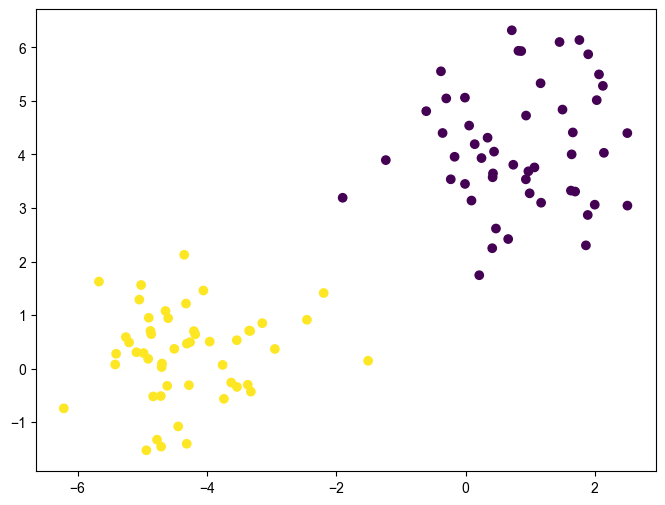

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn

from sklearn.datasets import make_blobs

N = 100  # number of samples
D = 2  # number of dimensions
C = 2  # number of classes
seed = 3  # for reproducible experiments

X, y = make_blobs(n_samples=N, n_features=D, centers=2, random_state=seed)
y[y == 0] = -1  # Change 0 labels to -1 for convenience
y = y.astype(float)

plt.figure(figsize=[8, 6])
plt.scatter(X[:, 0], X[:, 1], c=y)

# Now that seaborn is imported, setting the style should work
sns.set_style('darkgrid')  # You can also use seaborn's set_style method for more options

plt.show()

## Solving the SVM dual problem

The general form of a quadratic problem is:<br/><br/>
Objective function:<br/>
$$\min_{\mathbf{x}} \frac{1}{2}\mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T \mathbf{x}$$
Subject to:<br/>
$$\quad \mathbf{G}\mathbf{x} \preceq \mathbf{h}$$
And:<br/>
$$ \quad \mathbf{A}\mathbf{x} = \mathbf{b}$$

To use CVXOPT, we have to find the matrices P, G and A as well as vectors q, h, b and put the in the proper matrix form for the CVXOPT algorithm. 

<b>Parameters:</b><br/>
<i>X</i> : array, shape [N, D] (Input features)<br/>
<i>y</i> : array, shape [N] (Binary class labels (scaled to [-1, 1] ))<br/>
<b>Returns:</b><br/>
<i>alphas</i> : array, shape [N] (Solution of the dual problem)


In [12]:
def solve_dual_svm(X, y):

    NUM = X.shape[0]
    DIM = X.shape[1]

    K = y[:, None] * X
    print(K.shape)
    print(y.shape)
    print(X.shape)
    K = np.dot(K, K.T)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x'])

    return alphas

## Retrieving the weights and the bias

Using the dual solution alpha, we can retrieve the weights <i>w</i> and the bias <i>b</i>.

<b>Parameters:</b><br/>
<i>X</i> : array, shape [N, D] (Input features)<br/>
<i>y</i>: array, shape [N] (Binary class labels (scaled to [-1, 1] ))<br/>
<i>alpha</i> : array, shape [N] (Solution of the dual problem)<br/>
<b>Returns:</b><br/>
<i>w</i> : array, shape [D] (Weight vector)<br/>
<i>b</i> : float (Bias term)

In [13]:
def compute_weights_and_bias(alpha, X, y):

    # get weights
    w = np.sum(alpha * y[:, None] * X, axis = 0)
    # get bias
    cond = (alpha > 1e-4).reshape(-1)
    b = y[cond] - np.dot(X[cond], w)
    b = b[0]
    
    return w, b

## Visualizing the result

In [14]:
def plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b):
   
    mpl.style.use('seaborn')
    plt.figure(figsize=[8, 6])
    # Plot the hyperplane
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.linspace(X[:, 0].min(), X[:, 0].max())
    plt.plot(x, x * slope + intercept, 'k-', label='decision boundary')
    # Plot all the datapoints
    plt.scatter(X[:, 0], X[:, 1], c=y)
    # Mark the support vectors
    support_vecs = (alpha > 1e-4).reshape(-1)
    plt.scatter(X[support_vecs, 0], X[support_vecs, 1], c=y[support_vecs], s=250, marker='*', label='support vectors')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(loc='upper left')

In [15]:
alpha = solve_dual_svm(X, y)
w, b = compute_weights_and_bias(alpha, X, y)
print("Weights: ", w)
print("Bias term: ", b)


(100, 2)
(100,)
(100, 2)
Weights:  [-0.69192638 -1.00973312]
Bias term:  0.907667823969647


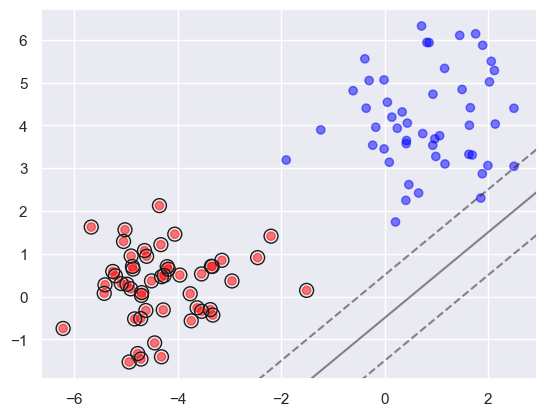

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b):
    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.5)
    
    # Create a grid to plot the decision boundaries
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    
    # Calculate the decision function
    Z = (np.dot(np.c_[xx.ravel(), yy.ravel()], w) + b).reshape(xx.shape)
    
    # Plot decision boundary and margins
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # Highlight support vectors (this is optional and requires alpha values)
    # You might want to adjust this part based on how your support vectors are defined
    sv = X[alpha > 1e-5]
    plt.scatter(sv[:, 0], sv[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')

# Example usage
# Assuming w, b, and alpha are defined from your SVM model
# Here's a dummy example for w, b, and alpha, replace with your actual model parameters
w = np.array([1, -1])
b = -0.5
alpha = np.random.rand(len(y)) * (y == 1)  # Random example, replace with actual alpha

plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b)
plt.show()
